## Solutions to MCMC assignment

0. Load the cars dataset from data directory. Make a scatterplot of the horsepower against the mpg.
Note: there might be some bad data points; feel free to drop them.

In [1]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression

/Users/jackbennetto/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/jackbennetto/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
df = pd.read_csv('data/cars.csv')

In [3]:
df = df[df.horsepower != '?']

In [4]:
df.horsepower = df.horsepower.astype('float64')

Text(0.5, 1.0, 'Cars')

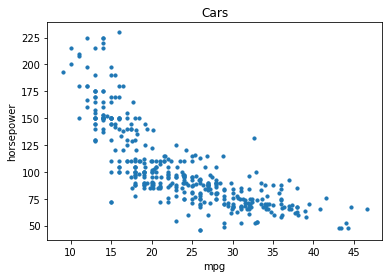

In [5]:
fig, ax = plt.subplots()
ax.scatter(df.mpg, df.horsepower, s=10)
ax.set_xlabel('mpg')
ax.set_ylabel('horsepower')
ax.set_title('Cars')

1. Use pymc3 to create a linear model predicting the horsepower from the mpg. You will have three parameters: beta0 (the intercept), beta1 (the slope), and sigma (the standard deviation of the error), with some reasonable values. Use a Normal distribution as prior for the first two, and a HalfNormal for the third. The observed values will follow a Normal distribution, based on those value and the horsepower.

In [6]:
with pm.Model() as model:
    beta0 = pm.Normal('beta0', 0, 1000)
    beta1 = pm.Normal('beta1', 0, 100)
    sigma = pm.HalfNormal('sigma', 100)
    observed = pm.Normal('observed', mu=beta0 + beta1*df.mpg, sd=sigma, observed=df.horsepower)  

2. Use find_MAP to find the maximum a posteriori results. Compare this to the results from in the model chosen by sklearn. Do you expect them to be the same? Are they?

In [7]:
with model:
    print(pm.find_MAP())

/Users/jackbennetto/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1,822.4, ||grad|| = 2.1809e-06: 100%|██████████| 42/42 [00:00<00:00, 1726.98it/s]  


{'beta0': array(194.47252174), 'beta1': array(-3.83876722), 'sigma_log__': array(3.18344068), 'sigma': array(24.12963321)}


In [8]:
skmodel = LinearRegression()
skmodel.fit(df[['mpg']], df['horsepower'])
skmodel.intercept_, skmodel.coef_

(194.47564319018676, array([-3.83888803]))

**The parameters are the same, as expected, though the sklearn doesn't find a MLE value for sigma.**

3. Sample from your model to create a trace, and plot histograms of the values with plot_trace.

In [9]:
n_sample = 5000
with model:
    trace = pm.sample(n_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta1, beta0]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:14<00:00, 785.08draws/s]
The acceptance probability does not match the target. It is 0.9009548278452444, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2852f8d0>,
      dtype=object)

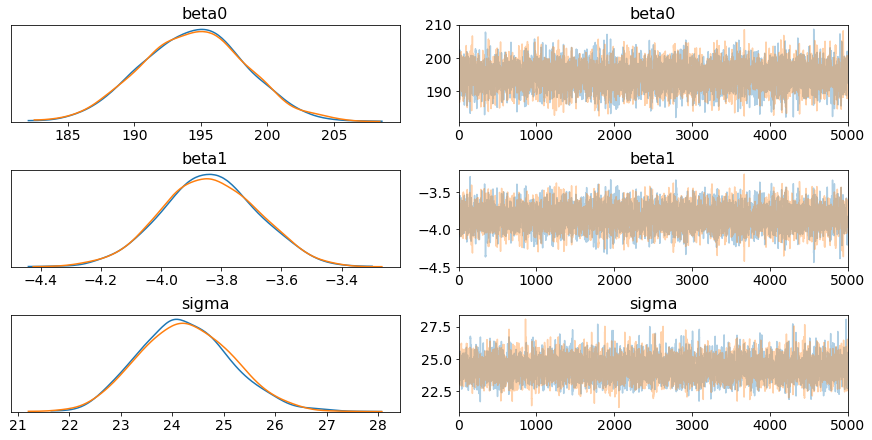

In [10]:
pm.traceplot(trace)

4. Show the various lines generated on top of the scatterplot of the data, by using at the beta0 and beta1 values of each element of the trace (note this will not show the values for sigma). To simplify it, only plot every 10th element of the trace.

(7.1148050994232594, 48.48519490057674)

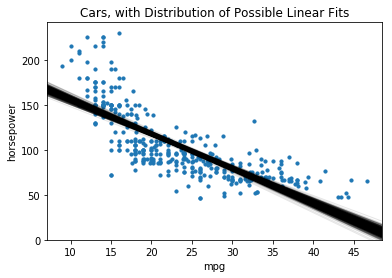

In [11]:
fig, ax = plt.subplots()
ax.scatter(df.mpg, df.horsepower, s=10)
ax.set_xlabel('mpg')
ax.set_ylabel('horsepower')
ax.set_title('Cars, with Distribution of Possible Linear Fits')
xlim = np.array(ax.get_xlim())
for i in range(0, n_sample, 10):
    ax.plot(xlim, trace[i]['beta0'] + trace[i]['beta1'] * xlim,
            c='k', lw=1, alpha=0.1)
ax.set_ylim(bottom=0)
ax.set_xlim(xlim)

5. The plot is not very linear. Try improving it by adding the square of the mpg as an additional feature and add that to your model.

In [12]:
with pm.Model() as model_poly:
    beta0 = pm.Normal('beta0', mu=0, sd=100)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=100)
    observed = pm.Normal('observed',
                         mu=beta0 + beta1*df.mpg.values + beta2*df.mpg.values**2,
                         sd=sigma,
                         observed=df.horsepower.values)

In [13]:
n_sample = 10000
with model_poly:
    trace = pm.sample(n_sample, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta2, beta1, beta0]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:29<00:00, 245.21draws/s]


/Users/jackbennetto/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


(0, 241.73458234787188)

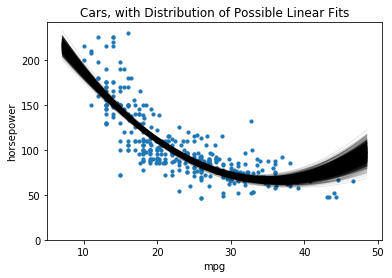

In [14]:
fig, ax = plt.subplots()
ax.scatter(df.mpg, df.horsepower, s=10)
ax.set_xlabel('mpg')
ax.set_ylabel('horsepower')
ax.set_title('Cars, with Distribution of Possible Linear Fits')
xpts = np.linspace(*ax.get_xlim(), 100)
for i in range(0, n_sample, 10):
    ax.plot(xpts, trace[i]['beta0'] +
                  trace[i]['beta1'] * xpts +
                  trace[i]['beta2'] * xpts ** 2,
            c='k', lw=1, alpha=0.1)
ax.set_ylim(ymin=0)

6. Fit the data using a linear spline with a single knot. Unlike the splines we used in the past, the model will choose the position of the knot.

You will have five parameters here: the x and y position of the knot, the slope of the line on either side of the knot, and sigma. For the first you can use a Uniform distribution.

For the observed variable use the function `pm.math.where`. This takes three arguments: the condition, the value if True, and the value if False.

Check pm.traceplot() to make sure the values are reasonable.

In [15]:
with pm.Model() as model_knot:
    knot_x = pm.Uniform('knot_x', df.mpg.min(), df.mpg.max())
    knot_y = pm.Normal('knot_y', mu=0, sd=200)
    beta1a = pm.Normal('beta1a', mu=0, sd=10)
    beta1b = pm.Normal('beta1b', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=100)
        
    observed = pm.Normal('observed',
                         mu=pm.math.where(df.mpg.values < knot_x,
                                          knot_y + beta1a*(df.mpg.values - knot_x),
                                          knot_y + beta1b*(df.mpg.values - knot_x)),
                         sd=sigma,
                         observed=df.horsepower.values)

In [16]:
n_sample = 5000
with model_knot:
    trace = pm.sample(n_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta1b, beta1a, knot_y, knot_x]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 527.71draws/s]
The acceptance probability does not match the target. It is 0.8797535584757569, but should be close to 0.8. Try to increase the number of tuning steps.


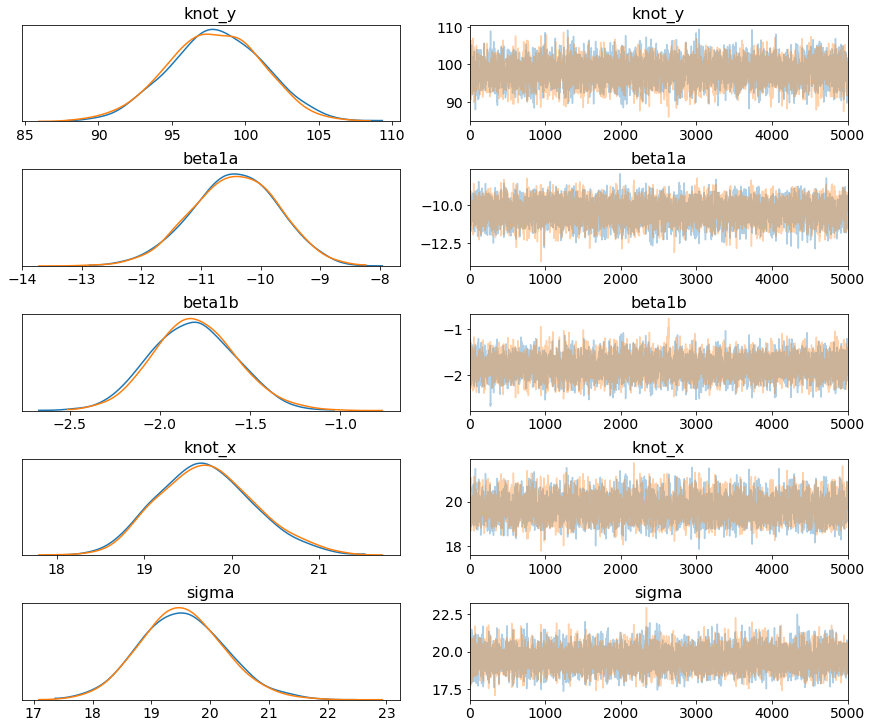

In [17]:
pm.traceplot(trace);

**The position of (knot_x, knot_y) on the scatterplot seems to be in the middle of the plot, as expected, and beta1a (the slop on the left) is steeper than beta1b (the slope on the right).**

7. Plot the linear splines on top of the data.

(0, 262.27998401886134)

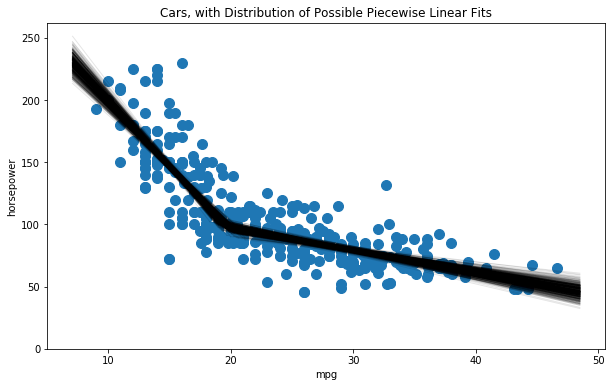

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df.mpg, df.horsepower, s=100)
ax.set_xlabel('mpg')
ax.set_ylabel('horsepower')
ax.set_title('Cars, with Distribution of Possible Piecewise Linear Fits')
start, end = ax.get_xlim()
for i in range(0, 5000, 10):
    knot_x = trace[i]['knot_x']
    knot_y = trace[i]['knot_y']
    beta1a = trace[i]['beta1a']
    beta1b = trace[i]['beta1b']

    ax.plot([start, knot_x],
            knot_y + beta1a * (np.array([start, knot_x]) - knot_x),
            c='k', lw=1, alpha=0.1)
    ax.plot([knot_x, end],
            knot_y + beta1b * (np.array([knot_x, end]) - knot_x),
            c='k', lw=1, alpha=0.1)

ax.set_ylim(bottom=0)

8. pymc3 has a glm module to simplify the expression of linear regression. To call that, replace the specifications of the variables with a line like `pm.glm.GLM.from_formula('horsepower ~ mpg', df)`. See http://docs.pymc.io/notebooks/GLM-linear.html for more information.

In [19]:
with pm.Model() as model_formula:
    pm.glm.GLM.from_formula('horsepower ~ mpg', df)

In [20]:
n_sample = 5000
with model_formula:
    trace = pm.sample(n_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mpg, Intercept]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:16<00:00, 678.94draws/s]
The acceptance probability does not match the target. It is 0.9056497494850235, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9442631980161229, but should be close to 0.8. Try to increase the number of tuning steps.


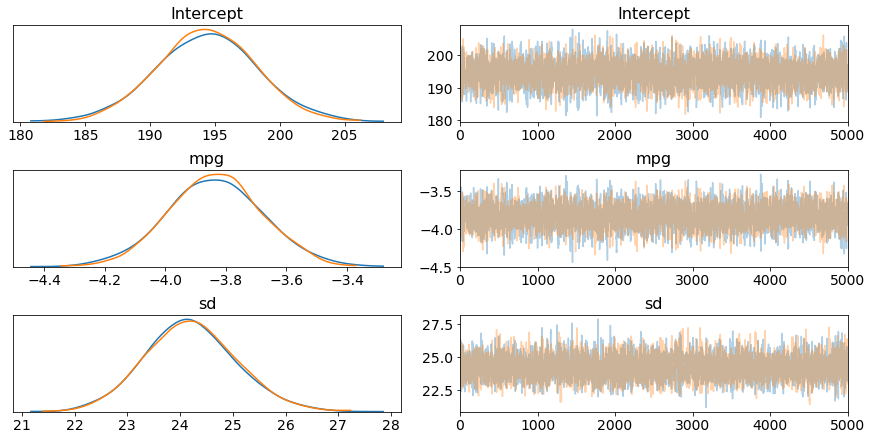

In [21]:
pm.traceplot(trace);

**Note that these are about the same as the betas and sd in the first model.**

9. The problem with that approach is that the horsepower is inherently non-negative. There are a few approaches you can take to build this into your model. The simplest is to predict the log of the horsepower, but you can also explore other distributions.

In [22]:
with pm.Model() as model_log:
    pm.glm.GLM.from_formula('np.log(horsepower) ~ mpg', df)

In [23]:
n_sample = 5000
with model_log:
    trace = pm.sample(n_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mpg, Intercept]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:15<00:00, 690.57draws/s]
The acceptance probability does not match the target. It is 0.945527779071498, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8994125656771075, but should be close to 0.8. Try to increase the number of tuning steps.


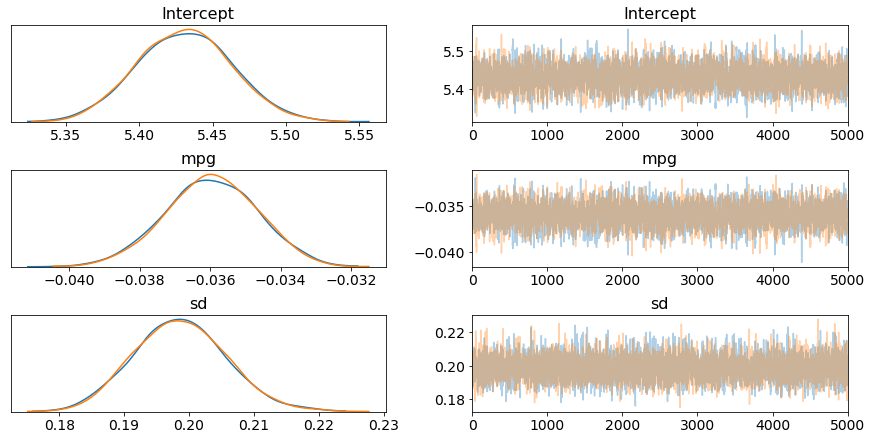

In [24]:
pm.traceplot(trace);

In [25]:
trace[0]

{'Intercept': 5.428321446422974,
 'mpg': -0.03613007727455734,
 'sd_log__': -1.6113009387538666,
 'sd': 0.19962774160731003}

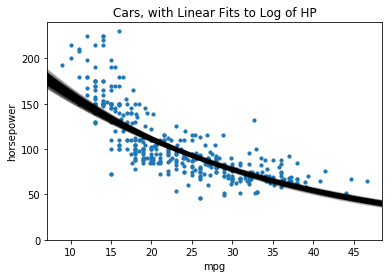

In [26]:
fig, ax = plt.subplots()
ax.scatter(df.mpg, df.horsepower, s=10)
ax.set_xlabel('mpg')
ax.set_ylabel('horsepower')
ax.set_title('Cars, with Linear Fits to Log of HP')
xlim = ax.get_xlim()
xpts = np.linspace(*xlim)
for i in range(0, n_sample, 10):
    ax.plot(xpts, np.exp(trace[i]['Intercept'] + trace[i]['mpg'] * xpts),
            c='k', lw=1, alpha=0.1)
ax.set_ylim(bottom=0)
ax.set_xlim(xlim)
plt.savefig('mpg_with_lines')

10. Use the scatter_matrix in pandas function to choose other features that predict horsepower. Add these to the linear model.

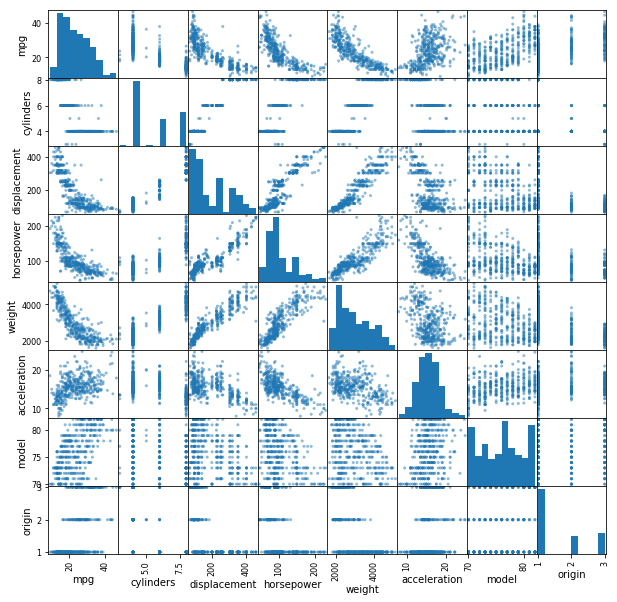

In [27]:
pd.plotting.scatter_matrix(df, figsize=(10, 10));

In [28]:
# using a formula gave an error suggested the prior wasn't sufficiently informative,
# so I'm going back to the hand-built model.
with pm.Model() as model_multi:
    beta0 = pm.Normal('beta0', 0, 1000)
    beta1 = pm.Normal('beta1', 0, 100)
    beta2 = pm.Normal('beta2', 0, 100)
    sigma = pm.HalfNormal('sigma', 100)
    observed = pm.Normal('observed',
                         mu=beta0 + beta1*df.mpg + beta2*df.weight,
                         sd=sigma,
                         observed=df.horsepower)  

In [29]:
n_sample = 2000
with model_multi:
    trace = pm.sample(n_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta2, beta1, beta0]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:20<00:00, 246.56draws/s]
The acceptance probability does not match the target. It is 0.8793309000697459, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9003945634575117, but should be close to 0.8. Try to increase the number of tuning steps.


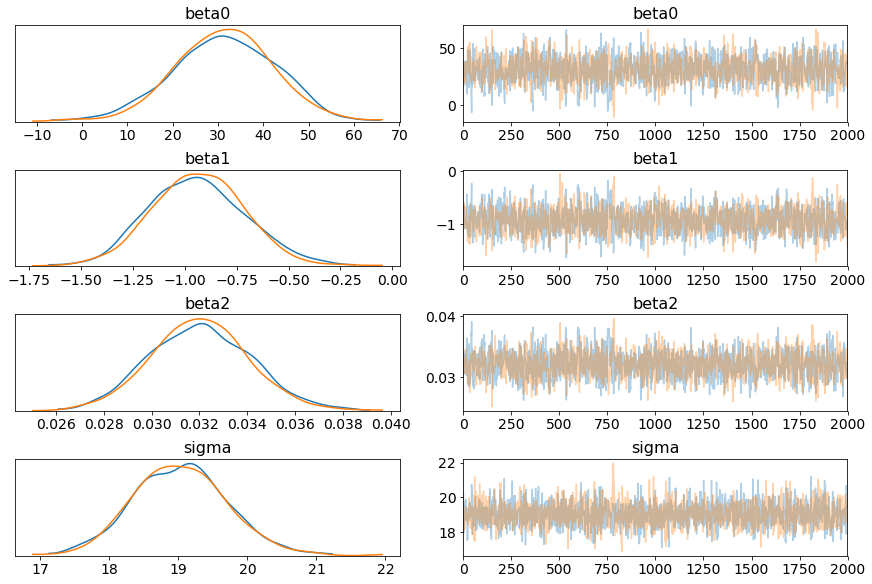

In [30]:
pm.traceplot(trace);